# From Annealing To Metropolis

##### Keywords: simulated annealing, detailed balance, stationarity, metropolis, boltzmann distribution,  irreducible, equilibrium, curse of dimensionality

In [2]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Contents
{:.no_toc}
* 
{: toc}

## Simulated Annealing

As we have seen, in Simulated Annealing, we reduce the temperature while accepting proposlas which increase the energy (the function we want to minimize).

The  probability of accepting a proposal is proportional to

$$A=\exp{ ( -\Delta f/kT)}$$ 

where $k$ is the Boltzmann constant and $T$ is the 
temperature.

This happens because, in simulated annealing, our physics analogy is that we are looking at a system in equilibrium, with a Boltzmann distribution of energies:

$p(X=i) = \frac{1}{Z(T)} \exp{ \left( \frac{-E_i}{kT}\right) }$$
 
 where 
 
 $$Z(T) = \sum_j \exp{ \left( \frac{ -E_j}{kT}\right)}$$
 
 is the normalization constant of the distribution, also called the partition function.

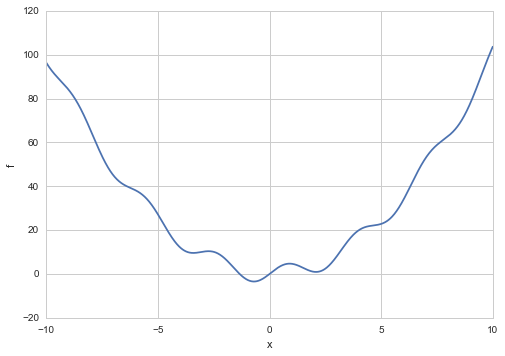

In [4]:
f = lambda x: x**2 + 4*np.sin(2*x)
xs = np.linspace(-10.,10.,1000)
plt.plot(xs, f(xs));
plt.xlabel('x')
plt.ylabel('f');

Simulated Annealing works by us making a proposal to change the current state, and then calculating the new energy of the state. We mentioned earlier that this works because simulated annealing produces a set of homogeneous markov chains, one at each temperature. We will explore this idea soon, but intuitively speaking, we can see that Simulated Annealing **samples** the boltzmann distribution by using our proposal "distribution".(It is critical that this proposal is symmetric, or supports what we have been calling detailed balance, which in our physical analogy corresponds to  isothermal reversibility.

This was the argument we made then, promising we would explain it later:

This *detailed balance* condition ensures that the sequence of $\{x_t\}$ generated by simulated annealing is a stationary markov chain with the boltzmann distribution as the stationary distribution of the chain as $t \to \infty$. 

By stationary distribution, we mean an unchanging one. We'll define this carefully in the notes on Markov Chains.

Or, in physics words, you are in equilibrium .


If you think of our example in terms of the Boltzmann probability distribution as the stationary distribution, then you can identify

$$p_{T}(x) = e^{-f(x)/T}$$ 

as the probability distribution we get down to.  Specifically let $p(x) = p_{1}(x)$. Then $f(x) = - log(p(x))$. 

But even more interesting:

$$P_{T}(x) = P(x)^{1/T}$$

and so you get a peakier and peakier distribution as $T \to 0$ around the global minimum (the globality and the exponentiation ensures that this peak is favored over the rest in the dfunction $f$). You can see this in the diagram below. As $T \to 0$, we get towards a delta function at the optimum and get a global minimum instead of a distribution.

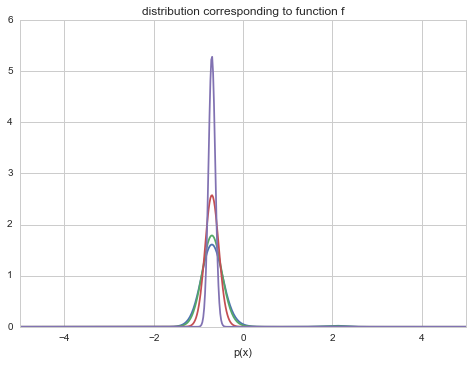

In [5]:
import functools
distx = lambda g, x: np.e**(-g(x))
dxf = functools.partial(distx, f)
outx = np.linspace(-10, 10,1000)
import scipy.integrate as integrate
O=20
plt.plot(outx, dxf(outx)/integrate.quad(dxf,-O, O)[0]);
A=integrate.quad(lambda x: dxf(x)**1.2,-O, O)[0]
plt.plot(outx, (dxf(outx)**1.2)/A);
B=integrate.quad(lambda x: dxf(x)**2.4,-O, O)[0]
plt.plot(outx, (dxf(outx)**2.4)/B);
C=integrate.quad(lambda x: dxf(x)**10,-O, O)[0]
plt.plot(outx, (dxf(outx)**10)/C);


plt.xlim([-5,5])
plt.xlabel('x')
plt.xlabel('p(x)')
plt.title("distribution corresponding to function f")

## Motivating Metropolis

Lets turn the question on its head. Suppose we wanted to sample from  a distribution $p(x)$ (corresponding to a minimization of energy $-log(p(x))$). 

In this case, we can now use a symmetric proposal to sample from $p(x)$ (this will keep things "reversible"). The criterion for the proposal being able to reach any other point in a finite series of operations is called **irreducibility** or the notion that we wont get any disconnected sets. Clearly we need our proposal to be able to go everywhere on the support of the distribution...

So we stick to one temperature $T=1$, and sample from $p(x)$ using the same techniques we learnt in simulated annealing. We:

1. use a proposal distribution to propose a step. 
2. Then we calculate the pdf at that step, and compare it to the one at the previous step. 
3. If the probability increased (energy decreased) we accept. If probability decreased (energy increased) we accept some of the time, based on the ratio of the new probability to the old one.
4. We accumulate our samples, as we are now trying to sample a distribution rather than find its "global maximum".

In [88]:
def metropolis(p, qdraw, nsamp, xinit):
    samples=np.empty(nsamp)
    x_prev = xinit
    for i in range(nsamp):
        x_star = qdraw(x_prev)
        p_star = p(x_star)
        p_prev = p(x_prev)
        pdfratio = p_star/p_prev
        if np.random.uniform() < min(1, pdfratio):
            samples[i] = x_star
            x_prev = x_star
        else:#we always get a sample
            samples[i]= x_prev
            
    return samples

## Example: Sampling a Gaussian

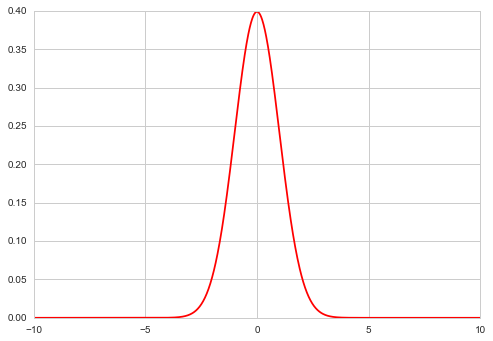

In [101]:
xxx= np.linspace(-10,10,1000)
plt.plot(xxx, norm.pdf(xxx), 'r'); 

In [102]:
from scipy.stats import uniform
def propmaker(delta):
    rv = uniform(-delta, 2*delta)
    return rv
uni = propmaker(0.5)
def uniprop(xprev):
    return xprev+uni.rvs()

In [103]:
norm.pdf(0.1)

0.39695254747701181

In [105]:
samps = metropolis(norm.pdf, uniprop, 100000, 0.0)

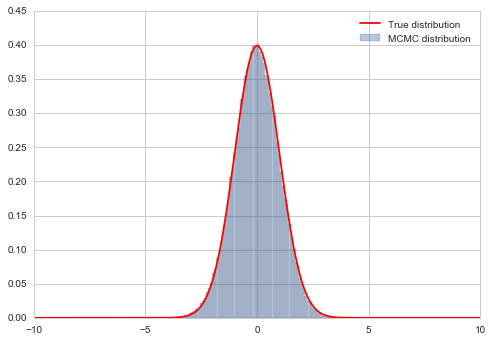

starting point was  0.0


In [106]:
# plot our sample histogram
plt.hist(samps,bins=80, alpha=0.4, label=u'MCMC distribution', normed=True) 

#plot the true function
xx= np.linspace(0,1,100)
plt.plot(xxx, norm.pdf(xxx), 'r', label=u'True distribution') 
plt.legend()

plt.show()
print("starting point was ", 0.0)

## Motivating Metropolis: why not Rejection Sampling, etc?

We've learnt how to do the inverse transform and how to use rejection sampling with a majorizing function. So why not use these methods to sample a distribution?

It can be hard to find a majorizing $g(x)$ and this gets even harder for multidimensional $g(x)$...and to boot less efficient as you leave more and more space out. Also, our general ideais to compute expectations as sample averages, and majorizing in multiple dimensions can have us spending a lot of time in tails of distributions.

Also note that the integrals being calculated in these expectations are of the type:

$$E_f[g] = \int dV f(x) g(x).$$

In multiple domensions, volume elements get smaller and smaller...the curse of dimensionality. This can be seen in the diagram :

![](images/cod.png)

(image from Betancourt)

where the centre-partitions combination to an integral goes from 1/3rd to 1/27th. Now suppose the  mode of the distibution is contained in this partition: then its contribution to the integral is going down with dimensions.

As the centre volume decreases, the outer volume increases, but this is in distribution tails, so we dont get much of a contribution from there either:

![](images/cod2.png)

(image from Betancourt)

(the slivers outside increase).

It is the neighborhood between these extremes, called the **typical set** which our sampler must explore well. And to get a good rejection sampling majorizer for this becomes hard.

We'll come back to this picture later...

## Another example

In [107]:
f = lambda x: 6*x*(1-x)

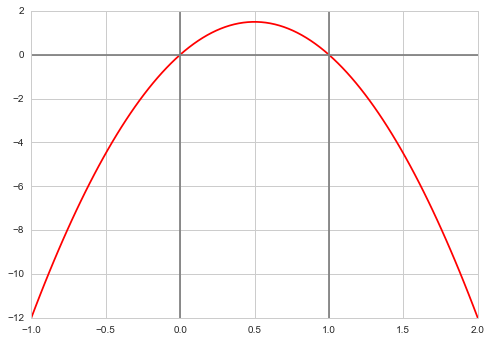

In [108]:
xxx= np.linspace(-1,2,100)
plt.plot(xxx, f(xxx), 'r') 
plt.axvline(0, 0,1, color="gray")
plt.axvline(1, 0,1, color="gray")
plt.axhline(0, 0,1, color="gray");

We wish to consider the support [0,1]. We could truncate our "distribution" beyond these. But it does not matter, even though we use a normal proposal whichcan propose negative and gretar-than-one $x$ values.

What happens if the proposal proposes a number outside of [0,1]? Notice then that our pdf is negative(ie it is not a pdf. (we could have defined it as 0 as well). Then in the metropolis acceptance formula, we are trying to check if a uniform is less than a negative or 0 number and we will not accept. This does however mean that we will need a longer set of samples than otherwise...

In [109]:
def prop(x):
    return np.random.normal(x, 0.6)

In [110]:
prop(0.1)

-0.38115925548141294

In [112]:
x0=np.random.uniform()
samps = metropolis(f, prop, 1000000, x0)

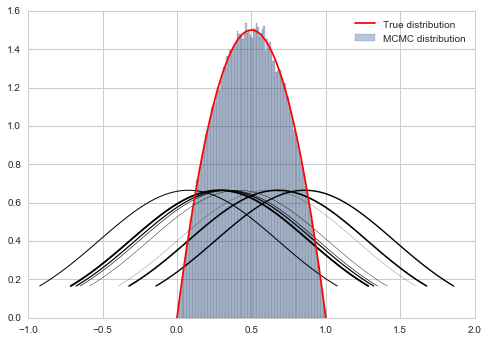

starting point was  0.16855486023328337


In [124]:
# plot our sample histogram
plt.hist(samps,bins=100, alpha=0.4, label=u'MCMC distribution', normed=True) 
somesamps=samps[0::100000]
for i,s in enumerate(somesamps):
    xs=np.linspace(s-1, s+1, 100)
    plt.plot(xs, norm.pdf(xs,s,0.6),'k', lw=i/5)
#plot the true function
xx= np.linspace(0,1,100)
plt.plot(xx, f(xx), 'r', label=u'True distribution') 
plt.legend()

plt.show()
print("starting point was ", x0)

What happens if we just reject samples from the normal proposal outside the range we are interested in? This seems like a legitimate thing to do: we are mixing rejection sampling with our Metropolis. However, you may realize that such a proposal has the problem of asymmetry: by rejecting in one direction we destroythe symmetry needed for "detailed balance" or equilibrium to hold.